# Data Processing

In [1]:
# --------------------------------------------------------------------------------------
# LIBRARIES
# --------------------------------------------------------------------------------------

# Basic libraries
from dotenv import load_dotenv
import os
import inspect
from tqdm.notebook import tqdm
import warnings
import pickle
import joblib

# Data libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

# Finance libraries
from talib import abstract as tl

# Math libraries
from pykalman import KalmanFilter

# Visualization tools
from plotly import express as px
from plotly import graph_objects as go
import plotly.io as pio
from IPython.display import display, Markdown
from torchviz import make_dot

# Modeling tools
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch
from torchmetrics import MeanAbsolutePercentageError
import optuna

# Personal libraries/modules
%load_ext autoreload
%autoreload 2
import data_processing as dp
import plotting_tools as pt
import model_utils as mu

In [2]:
# Libraries configurations
load_dotenv()
custom_template = pt.generate_plotly_transparent_template(
    color_sequence=pt.CYBERPUNK_COLOR_SEQUENCE,
    title_font_color=pt.FONT_COLOR,
    axis_font_color=pt.FONT_COLOR,
    axis_tick_color=pt.FONT_COLOR,
    axis_grid_color=pt.AXIS_COLOR,
    legend_font_color=pt.FONT_COLOR,
    plot_width=pt.WIDTH,
    plot_height=pt.HEIGHT
)
pio.templates.default = custom_template
pd.options.plotting.backend = 'plotly'
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device type = {device.type}')

# Filter out future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Device type = cuda


## Loading and Joining Data


In [3]:
# Load save data: this comes from the fundamental and market notebooks
fundamental_df = pd.read_parquet('data/fundamental_data.parquet')
market_df = pd.read_parquet('data/market_data.parquet')

## Feature Engineering

### Technical Analysis Variables

In [4]:
# --------------------------------------------------------------------------------------
# TECHNICAL INDICATORS
# --------------------------------------------------------------------------------------

# Garman-Klass volatility
market_df['gk_volatility'] = dp.garman_klass_volatility(market_df)

# MACD: Moving Average Convergence/Divergence
cols = ['macd', 'macd_signal', 'macd_hist']
market_df[cols] = tl.MACD(
    market_df, 
    fastperiod=12, 
    slowperiod=26, 
    signalperiod=9
)

# RSI: Relative Strength Index
market_df['rsi'] = tl.RSI(market_df, timeperiod=14)

# Bollinger bands
bb_cols = ['bb_upperband', 'bb_middleband', 'bb_lowerband']
market_df[bb_cols] = tl.BBANDS(market_df, timeperiod=20, nbdevup=2., nbdevdn=2.)

# --------------------------------------------------------------------------------------
# MARKET SIGNALS BASED ON TECHNICAL INDICATORS
# --------------------------------------------------------------------------------------

# RSI signal
market_df = dp.identify_rsi_signals(market_df)

# MACD signal
market_df = dp.identify_macd_signals(market_df)

# Bollinger bands signal
market_df = dp.identify_bollinger_band_signals(market_df)


### Mathematical Transformations

In [5]:
# --------------------------------------------------------------------------------------
# KALMAN FILTER:
# The Kalman filter is used as replacement of moving averages, as it is more
# adaptive and it isn't bound to a static time window for its computation.
# --------------------------------------------------------------------------------------

# Construct a Kalman filter
kf = KalmanFilter(
    transition_matrices=[1], 
    observation_matrices=[1], 
    initial_state_mean=0, 
    initial_state_covariance=1, 
    observation_covariance=1, 
    transition_covariance=0.01
)

# Use the observed values of the price to get a rolling mean
state_means, _ = kf.filter(market_df['close'].values)
market_df['close_price_kf'] = state_means

In [6]:
# Get metadata for the Fourier Transform
period = 'daily'
returns_name = f'stock_{period}_returns'
min_date = (
    market_df.loc[market_df[returns_name].notna()].index.min() -
    np.timedelta64(1, 'D')
)

df = market_df.loc[
    '2011-01-03':,
    ['close', returns_name]
].copy()

In [7]:
# --------------------------------------------------------------------------------------
# FOURIER TRANSFORMS
# --------------------------------------------------------------------------------------
fourier_transform_list = list()
period_list = ['daily']

for period in tqdm(period_list):
    # Get metadata for the Fourier Transform
    returns_name = f'stock_{period}_returns'
    min_date = (
        market_df.loc[market_df[returns_name].notna()].index.min() -
        np.timedelta64(1, 'D')
    )
    
    df = market_df.loc[
        min_date:,
        ['close', returns_name]
    ].copy()

    # Get optimum Fourier Transform
    min_value, min_output, best_df = dp.optimize_function(
        func=dp.compute_rmse_from_std,
        df=df.fillna(0),
        price_name='close',
        returns_name=returns_name,
        prefix=period,
        bounds=(0.0, 4),
        tests=100,
        best_guess=0.6

    )

    # Print results
    print(f'{period}: RMSE = {min_output:.2f} | STD = {min_value:.2f}')

    # Save results
    fourier_transform_list.append(best_df)

    del df

  0%|          | 0/1 [00:00<?, ?it/s]

daily: RMSE = 20.00 | STD = 0.20


In [8]:
# ------------------------------------------------------------------------------
# MERGE AND SAVE ALL PROCESS DATA
# ------------------------------------------------------------------------------
total_df = market_df.merge(
    right=fourier_transform_list[0].loc[:, 'daily_theta':],
    how='left',
    left_index=True,
    right_index=True
)
total_df = total_df.merge(
    right=fundamental_df,
    how='left',
    left_index=True,
    right_index=True
)

total_df.to_parquet('data/processed_data.parquet')

## Compute Target Variable(s)
+ Here we could also compute a binary variable to predict if the returns or price variation will be positive or negative for the next period, or similar iterations on making a binary problem out of return prediction

## To do
+ [x] Check that the `TimeCNN` is well constructed: input batch shapes and outputs based in the number of variables.
+ [ ] Finish building the `TimeCNNRNN` network.
+ [ ] Optimize `TimeCNNRNN` network with first target variable.
+ [ ] Optimize `TimeCNN` by itself with the first target variable.
+ [ ] Test other target variables

In [3]:
# --------------------------------------------------------------------------------------
# LOAD DATA
# --------------------------------------------------------------------------------------
total_df = pd.read_parquet('data/processed_data.parquet').fillna(np.NaN)
daily_df =total_df.loc[:, :'daily_fft_regression']
quarterly_df = total_df.loc[:, 'is_1':]

# --------------------------------------------------------------------------------------
# ONE-HOT-ENCODE SIGNAL DATA
# --------------------------------------------------------------------------------------
signal_cols = ['rsi_signal', 'macd_signal_cross', 'bb_signal']

# Instantiate, fit and save the encoder
ohe_path = 'models/signal_ohe.pkl'

if os.path.exists(ohe_path):
    one_hot_encoder = pickle.load(open(ohe_path, 'rb'))
    print('One-hot-encoder loaded')
else:
    one_hot_encoder = OneHotEncoder()
    one_hot_encoder.fit(total_df[signal_cols])
    with open(ohe_path, 'wb') as f:
        pickle.dump(one_hot_encoder, f)
    print('One-hot-encoder fitted and saved')

# One-hot-encode signals
daily_df[one_hot_encoder.get_feature_names_out()] = one_hot_encoder.transform(
    daily_df[signal_cols]
).toarray()

# Drop nan-ohe columns
daily_df.drop(
    columns=[col for col in daily_df.columns if '_nan' in col], 
    inplace=True
)

# Select only numeric columns
daily_df = daily_df.select_dtypes(include='number')

One-hot-encoder loaded


In [4]:
daily_df.tail()

open        high         low       close    volume  EFFR  \
2023-12-04  369.100006  369.519989  362.899994  369.140015  32063300  5.33   
2023-12-05  366.450012  373.079987  365.619995  372.519989  23065000  5.33   
2023-12-06  373.540009  374.179993  368.029999  368.799988  21182100  5.33   
2023-12-07  368.230011  371.450012  366.320007  370.950012  23118900  5.33   
2023-12-08  369.200012  374.459991  368.230011  374.230011  20144800  5.33   

                 PCE  DGS3MO  DGS2  DGS5  DGS10  DGS20  DGS30  T10Y2Y  T10Y3M  \
2023-12-04  3.006568    5.46  4.64  4.23   4.28   4.61   4.43   -0.36   -1.18   
2023-12-05  3.006568    5.45  4.57  4.14   4.18   4.48   4.30   -0.39   -1.27   
2023-12-06  3.006568    5.45  4.60  4.12   4.12   4.40   4.22   -0.48   -1.33   
2023-12-07  3.006568    5.44  4.58  4.11   4.14   4.42   4.25   -0.44   -1.30   
2023-12-08  3.006568    5.44  4.58  4.11   4.14   4.42   4.25   -0.48   -1.21   

            DTWEXBGS         spy    vix  market_daily_returns  \
2023-12-04  120.3697  456.690002  13.08             -0.005249   
2023-12-05  120.3697  456.600006  12.85             -0.000197   
2023-12-06  120.3697  454.760010  12.97             -0.004030   
2023-12-07  120.3697  458.230011  13.06              0.007630   
2023-12-08  120.3697  460.200012  12.35              0.004299   

            market_weekly_returns  market_monthly_returns  \
2023-12-04               0.004863                0.060196   
2023-12-05               0.003671                0.050404   
2023-12-06               0.000330                0.043770   
2023-12-07               0.004010                0.048749   
2023-12-08               0.002396                0.052487   

            stock_daily_returns  stock_weekly_returns  stock_monthly_returns  \
2023-12-04            -0.014339             -0.025012               0.061924   
2023-12-05             0.009156             -0.026601               0.058039   
2023-12-06            -0.009986             -0.026528               0.036515   
2023-12-07             0.005830             -0.021008               0.030990   
2023-12-08             0.008842             -0.000748               0.032460   

            daily_beta  daily_alpha  weekly_beta  weekly_alpha  monthly_beta  \
2023-12-04    1.194981    -0.001124     1.106159      0.000574      1.025443   
2023-12-05    1.194848    -0.000341     1.107276     -0.002718      1.029095   
2023-12-06    1.195019    -0.000701     1.108444     -0.005267      1.034673   
2023-12-07    1.194917    -0.000894     1.108952     -0.007392      1.038576   
2023-12-08    1.194990    -0.000551     1.108831     -0.006972      1.040666   

            monthly_alpha  gk_volatility      macd  macd_signal  macd_hist  \
2023-12-04       0.039578       0.008997  8.769866    10.350501  -1.580635   
2023-12-05       0.034555       0.003753  8.033750     9.887151  -1.853401   
2023-12-06       0.028006       0.013219  7.068716     9.323464  -2.254748   
2023-12-07       0.020945       0.004111  6.403592     8.739490  -2.335897   
2023-12-08       0.014639       0.003161  6.071161     8.205824  -2.134663   

                  rsi  bb_upperband  bb_middleband  bb_lowerband  \
2023-12-04  54.913174    386.024557     371.330493    356.636429   
2023-12-05  57.765689    385.019697     372.166101    359.312505   
2023-12-06  53.736117    384.281690     372.616113    360.950537   
2023-12-07  55.661236    383.778601     373.040398    362.302194   
2023-12-08  58.498466    382.660842     373.753928    364.847014   

            close_price_kf  daily_theta  daily_amplitude  daily_frequency  \
2023-12-04      368.681631    -0.300220         0.000385        -0.000526   
2023-12-05      369.046755     1.308782         0.000478        -0.000421   
2023-12-06      369.023281    -0.237249         0.000203        -0.000315   
2023-12-07      369.206561    -0.180290         0.000227        -0.000210   
2023-12-08      369.684417     0.507438         0.000935        -0.000105   

 

In [5]:
# --------------------------------------------------------------------------------------
# DEFINE TARGET VARIABLE:
# - Try future returns: daily
# - Try future price: daily
# - Try future movement signal: daily
# --------------------------------------------------------------------------------------
daily_df['t1_close'] = daily_df['close'].shift(-1)
daily_df.dropna(subset=['t1_close'], inplace=True)
daily_df = daily_df.loc['2006-01-03':]
daily_df.tail()

open        high         low       close    volume  EFFR  \
2023-12-01  376.760010  378.160004  371.309998  374.510010  33020400  5.33   
2023-12-04  369.100006  369.519989  362.899994  369.140015  32063300  5.33   
2023-12-05  366.450012  373.079987  365.619995  372.519989  23065000  5.33   
2023-12-06  373.540009  374.179993  368.029999  368.799988  21182100  5.33   
2023-12-07  368.230011  371.450012  366.320007  370.950012  23118900  5.33   

                 PCE  DGS3MO  DGS2  DGS5  DGS10  DGS20  DGS30  T10Y2Y  T10Y3M  \
2023-12-01  3.006568    5.43  4.56  4.14   4.22   4.58   4.40   -0.34   -1.21   
2023-12-04  3.006568    5.46  4.64  4.23   4.28   4.61   4.43   -0.36   -1.18   
2023-12-05  3.006568    5.45  4.57  4.14   4.18   4.48   4.30   -0.39   -1.27   
2023-12-06  3.006568    5.45  4.60  4.12   4.12   4.40   4.22   -0.48   -1.33   
2023-12-07  3.006568    5.44  4.58  4.11   4.14   4.42   4.25   -0.44   -1.30   

            DTWEXBGS         spy    vix  market_daily_returns  \
2023-12-01  120.3697  459.100006  12.63              0.005916   
2023-12-04  120.3697  456.690002  13.08             -0.005249   
2023-12-05  120.3697  456.600006  12.85             -0.000197   
2023-12-06  120.3697  454.760010  12.97             -0.004030   
2023-12-07  120.3697  458.230011  13.06              0.007630   

            market_weekly_returns  market_monthly_returns  \
2023-12-01               0.008346                0.086216   
2023-12-04               0.004863                0.060196   
2023-12-05               0.003671                0.050404   
2023-12-06               0.000330                0.043770   
2023-12-07               0.004010                0.048749   

            stock_daily_returns  stock_weekly_returns  stock_monthly_returns  \
2023-12-01            -0.011612             -0.007736               0.084376   
2023-12-04            -0.014339             -0.025012               0.061924   
2023-12-05             0.009156             -0.026601               0.058039   
2023-12-06            -0.009986             -0.026528               0.036515   
2023-12-07             0.005830             -0.021008               0.030990   

            daily_beta  daily_alpha  weekly_beta  weekly_alpha  monthly_beta  \
2023-12-01    1.194625    -0.000565     1.105001      0.004221      1.022366   
2023-12-04    1.194981    -0.001124     1.106159      0.000574      1.025443   
2023-12-05    1.194848    -0.000341     1.107276     -0.002718      1.029095   
2023-12-06    1.195019    -0.000701     1.108444     -0.005267      1.034673   
2023-12-07    1.194917    -0.000894     1.108952     -0.007392      1.038576   

            monthly_alpha  gk_volatility      macd  macd_signal  macd_hist  \
2023-12-01       0.046410       0.011454  9.925999    10.745660  -0.819661   
2023-12-04       0.039578       0.008997  8.769866    10.350501  -1.580635   
2023-12-05       0.034555       0.003753  8.033750     9.887151  -1.853401   
2023-12-06       0.028006       0.013219  7.068716     9.323464  -2.254748   
2023-12-07       0.020945       0.004111  6.403592     8.739490  -2.335897   

                  rsi  bb_upperband  bb_middleband  bb_lowerband  \
2023-12-01  60.990313    387.392906     370.477762    353.562618   
2023-12-04  54.913174    386.024557     371.330493    356.636429   
2023-12-05  57.765689    385.019697     372.166101    359.312505   
2023-12-06  53.736117    384.281690     372.616113    360.950537   
2023-12-07  55.661236    383.778601     373.040398    362.302194   

            close_price_kf  daily_theta  daily_amplitude  daily_frequency  \
2023-12-01      368.633444    -0.496884         0.000258        -0.000631   
2023-12-04      368.681631    -0.300220         0.000385        -0.000526   
2023-12-05      369.046755     1.308782         0.000478        -0.000421   
2023-12-06      369.023281    -0.237249         0.000203        -0.000315   
2023-12-07      369.206561    -0.180290         0.000227        -0.000210   

 

In [7]:
# --------------------------------------------------------------------------------------
# DEFINE HYPERPARAMETER OPTIMIZATION TARGET
# --------------------------------------------------------------------------------------
# Define input variables
num_vars = daily_df.shape[1] - 1
UNITS_OPTION_LIST = [64, 128,  256, 512, 1024]
ACTIVATION_OPTION_LIST = ['Softplus', 'ReLU', 'ELU', 'Tanh']
BATCH_SIZES = [2**i for i in range(3, 10)]
OPTIMIZER_OPTION_LIST = ['Adam', 'AdamW', 'NAdam', 'RAdam', 'RMSprop']
EPOCHS = 50

def objective(trial):
    """Takes the trial object from the Optuna optimization process, 
    defines the hyper-parameters of the model and traning process,
    and produces and trains the model.
    
    For the different types of hyperparameter selections see the 
    documentation 
    https://optuna.readthedocs.io/en/stable/reference/generated/optuna.trial.Trial.html
    
    Args:
        trial: Optuna Trial object
        
    """
    
    # ----------------------------- Hyperparameter definition --------------------------
    # Define the  CNN hyperparameters
    time_window = trial.suggest_int('cnn_time_window', 5, 21, step=2)
    cnn_individual_channels = trial.suggest_int('cnn_individual_channels', 1, 30)
    cnn_synthesized_channels = trial.suggest_int('cnn_synthesized_channels', 10, 100)
    cnn_layers = trial.suggest_int('cnn_layers', 1, 5)
    cnn_batch_norm = trial.suggest_categorical('cnn_batch_norm', choices=[True, False])
    
    # Define the RNN hyperparameters
    rnn_units = trial.suggest_categorical('rnn_units', choices=UNITS_OPTION_LIST)
    rnn_layers = trial.suggest_int('rnn_layers', 1, 5)
    rnn_batch_norm = trial.suggest_categorical('rnn_batch_norm', choices=[True, False])
    rnn_unit_type = trial.suggest_categorical('rnn_unit_type', choices=['LSTM', 'GRU'])
    
    # Define the dense hyperparameters
    dense_layers = trial.suggest_int('dense_layers', 1, 5)
    dense_units = trial.suggest_categorical('dense_units', choices=UNITS_OPTION_LIST)
    dense_batch_norm = trial.suggest_categorical(
        'dense_batch_norm', choices=[True, False]
    )
    dense_activation = trial.suggest_categorical(
        'dense_activation', choices=ACTIVATION_OPTION_LIST
    )
    
    # Define the time sequence length for the recurrent dimension
    time_steps = trial.suggest_int('time_steps', 40, 120, step=5)
    
    # Define batch size
    batch_size = trial.suggest_categorical('batch_size', choices=BATCH_SIZES)
    
    # Define learning rate: log domain
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    
    # Define learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau
    
    # Define the optimizer
    optimizer_name = trial.suggest_categorical(
        'optimizer_name', choices=OPTIMIZER_OPTION_LIST
    )
    
    
    # ----------------------------  Build Training-Test Datasets -----------------------
    # Build batch x time_steps x variables arrays
    x_train, y_train, x_test, y_test = mu.series_to_sequence(
        data=daily_df,
        window_size=time_steps,
        num_target_vars=1,
        test_split=0.25
    )
    
    # Build the Tensor Datasets
    train_dataset = TensorDataset(
        torch.tensor(x_train, dtype=torch.float),
        torch.tensor(y_train, dtype=torch.float)
    )
    val_dataset = TensorDataset(
        torch.tensor(x_test, dtype=torch.float),
        torch.tensor(y_test, dtype=torch.float)
    )
    
    # Build PyTorch data loaders
    if len(train_dataset) % batch_size == 1:
        drop_last = True
    else:
        drop_last = False
        
    train_dataloader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=drop_last
    )
    
    if len(val_dataset) % batch_size == 1:
        drop_last = True
    else:
        drop_last = False
        
    val_dataloader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=drop_last
    )
    
    # --------------------------------  Build Model ------------------------------------
    # Neural network model
    model = mu.TimeCNNRNN(
        dense_layers=dense_layers,
        dense_units=dense_units,
        dense_batch_norm=dense_batch_norm,
        dense_activation=dense_activation,
        rnn_units=rnn_units,
        rnn_layers=rnn_layers,
        rnn_batch_norm=rnn_batch_norm,
        rnn_unit_type=rnn_unit_type,
        num_vars=x_train.shape[-1],
        time_steps=time_steps,
        time_window=time_window,
        cnn_individual_channels=cnn_individual_channels,
        cnn_synthesized_channels=cnn_synthesized_channels,
        cnn_layers=cnn_layers,
        cnn_batch_norm=cnn_batch_norm,
        n_target_vars=y_train.shape[-1]
    ).to(device) # send model to GPU if available (this is define above)
    
    # Define optimizer
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=learning_rate)
    
    # Define learning rate scheduler:
    """This scheduler looks to the loss: if it hasn't decreased for `patience` number
    of epochs, then it reduces the learning rate. You can find the documentation
    https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html
    """
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer,
        mode='min',
        factor=0.1,
        patience=3,
        verbose=True
    )
    
    # Define the loss function
    criterion = nn.MSELoss()
    
    # Define validation function: send to device aswell
    mape_val_function = MeanAbsolutePercentageError().to(device)
    
    # --------------------------------  Training Loop ----------------------------------
    for epoch in range(EPOCHS):
        # Save batch losses for the scheduler
        epoch_losses = list()
        
        # Set the model to train mode
        model.train()
        
        # Iterate through batches
        for x, y in train_dataloader:
            
            # Send tensors to device (GPU if available)
            x, y = x.to(device), y.to(device)
            
            # Reset gradients for the optimizer
            optimizer.zero_grad()
            
            # Compute model output
            output = model(x)
            
            # Compute loss and backpropagate loss gradients
            loss = criterion(output, y)
            epoch_losses.append(loss.item())
            loss.backward()
            
            # Optimization step
            optimizer.step()
        
        # Compute the epoch average loss value
        mean_loss = sum(epoch_losses)/len(epoch_losses)
        
        # Give a step with scheduler
        scheduler.step(mean_loss)
        
        # ----------------------------  Validation Loop --------------------------------
        # Set the model to evaluation mode
        model.eval()
        
        # Set the loop with no gradient
        with torch.no_grad():
            mape_list = list()
            
            # Iterate through batches
            for x_val, y_val in val_dataloader:
                # Send tensors to devide: GPU if available
                x_val, y_val = x_val.to(device), y_val.to(device)
                
                # Compute output from model
                output = model(x_val)
                batch_mape = mape_val_function(output, y_val)
                mape_list.append(batch_mape.item())
        
        val_mape = sum(mape_list) / len(mape_list)
        
        # Save and report to trial
        trial.report(val_mape, epoch)
        
        # Handle pruning during optimization
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
        return val_mape

In [8]:
study = optuna.create_study(direction='minimize', study_name='CNNRNN_daily_close_price')
study.optimize(objective, n_trials=1000)

[I 2024-01-02 20:55:53,047] A new study created in memory with name: CNNRNN_daily_close_price
[I 2024-01-02 20:55:55,203] Trial 0 finished with value: 84.91455162896051 and parameters: {'cnn_time_window': 19, 'cnn_individual_channels': 8, 'cnn_synthesized_channels': 56, 'cnn_layers': 3, 'cnn_batch_norm': True, 'rnn_units': 512, 'rnn_layers': 1, 'rnn_batch_norm': False, 'rnn_unit_type': 'LSTM', 'dense_layers': 4, 'dense_units': 64, 'dense_batch_norm': True, 'dense_activation': 'ELU', 'time_steps': 115, 'batch_size': 128, 'learning_rate': 0.019867584132745954, 'optimizer_name': 'RMSprop'}. Best is trial 0 with value: 84.91455162896051.
[I 2024-01-02 20:55:55,459] Trial 1 finished with value: 0.7803041736284891 and parameters: {'cnn_time_window': 15, 'cnn_individual_channels': 14, 'cnn_synthesized_channels': 19, 'cnn_layers': 1, 'cnn_batch_norm': True, 'rnn_units': 64, 'rnn_layers': 1, 'rnn_batch_norm': False, 'rnn_unit_type': 'GRU', 'dense_layers': 2, 'dense_units': 512, 'dense_batch_nor

In [10]:
study.trials_dataframe().sort_values(by='value').head(50)

number     value             datetime_start          datetime_complete  \
961     961  0.054231 2024-01-02 21:38:12.724177 2024-01-02 21:38:14.493747   
940     940  0.056860 2024-01-02 21:37:31.149805 2024-01-02 21:37:33.361204   
903     903  0.073307 2024-01-02 21:35:50.050021 2024-01-02 21:35:52.633115   
951     951  0.074328 2024-01-02 21:37:51.007699 2024-01-02 21:37:52.745293   
953     953  0.075703 2024-01-02 21:37:54.599268 2024-01-02 21:37:56.352868   
644     644  0.079600 2024-01-02 21:23:24.533417 2024-01-02 21:23:26.800003   
854     854  0.090010 2024-01-02 21:33:49.669549 2024-01-02 21:33:52.309130   
635     635  0.090148 2024-01-02 21:23:09.444646 2024-01-02 21:23:11.147173   
614     614  0.096409 2024-01-02 21:22:15.280953 2024-01-02 21:22:17.231689   
835     835  0.099709 2024-01-02 21:33:05.050836 2024-01-02 21:33:06.758591   
240     240  0.100235 2024-01-02 21:09:47.861572 2024-01-02 21:09:49.093818   
205     205  0.109277 2024-01-02 21:08:49.947575 2024-01-02 21:08:51.801353   
278     278  0.113362 2024-01-02 21:10:40.797912 2024-01-02 21:10:42.520327   
643     643  0.115480 2024-01-02 21:23:22.986258 2024-01-02 21:23:24.532411   
715     715  0.118045 2024-01-02 21:25:29.664213 2024-01-02 21:25:37.131525   
484     484  0.119205 2024-01-02 21:16:42.003509 2024-01-02 21:16:47.606971   
690     690  0.120442 2024-01-02 21:24:41.945743 2024-01-02 21:24:43.514839   
945     945  0.121322 2024-01-02 21:37:41.261557 2024-01-02 21:37:43.128753   
974     974  0.123840 2024-01-02 21:38:35.327279 2024-01-02 21:38:37.066529   
913     913  0.125808 2024-01-02 21:36:18.436103 2024-01-02 21:36:21.108698   
995     995  0.127684 2024-01-02 21:39:18.170142 2024-01-02 21:39:20.166087   
658     658  0.132301 2024-01-02 21:23:48.562946 2024-01-02 21:23:50.085604   
399     399  0.136385 2024-01-02 21:13:39.888074 2024-01-02 21:13:40.972944   
476     476  0.152127 2024-01-02 21:16:09.807935 2024-01-02 21:16:15.420154   
999     999  0.152586 2024-01-02 21:39:24.661427 2024-01-02 21:39:26.618710   
702     702  0.153505 2024-01-02 21:25:01.093449 2024-01-02 21:25:03.476556   
841     841  0.156365 2024-01-02 21:33:19.295451 2024-01-02 21:33:20.964880   
308     308  0.161616 2024-01-02 21:11:24.640151 2024-01-02 21:11:25.804660   
895     895  0.163453 2024-01-02 21:35:29.313355 2024-01-02 21:35:31.882229   
890     890  0.164848 2024-01-02 21:35:21.149960 2024-01-02 21:35:22.809120   
647     647  0.167600 2024-01-02 21:23:30.557492 2024-01-02 21:23:32.227612   
918     918  0.169772 2024-01-02 21:36:32.063779 2024-01-02 21:36:34.826883   
906     906  0.172078 2024-01-02 21:35:56.261753 2024-01-02 21:35:58.889169   
725     725  0.174323 2024-01-02 21:26:29.987010 2024-01-02 21:26:34.852134   
448     448  0.175037 2024-01-02 21:14:54.713902 2024-01-02 21:14:57.662156   
450     450  0.177154 2024-01-02 21:14:59.682180 2024-01-02 21:15:04.120394   
660     660  0.177916 2024-01-02 21:23:51.554509 2024-01-02 21:23:52.779747   
309     309  0.179330 2024-01-02 21:11:25.805659 2024-01-02 21:11:27.107828   
933     933  0.180573 2024-01-02 21:37:16.491982 2024-01-02 21:37:19.182720   
374     374  0.181147 2024-01-02 21:12:58.923689 2024-01-02 21:13:00.291941   
444     444  0.181874 2024-01-02 21:14:46.784545 2024-01-02 21:14:48.644652   
315     315  0.182130 2024-01-02 21:11:33.060899 2024-01-02 21:11:34.125695   
528     528  0.186995 2024-01-02 21:19:07.915650 2024-01-02 21:19:10.809248   
245     245  0.192050 2024-01-02 21:09:54.818675 2024-01-02 21:09:55.987982   
618     618  0.193355 2024-01-02 21:22:23.941983 2024-01-02 21:22:26.348092   
581     581  0.193625 2024-01-02 21:21:09.220445 2024-01-02 21:21:10.408875   
990     990  0.193766 2024-01-02 21:39:06.945154 2024-01-02 21:39:08.684460   
958     958  0.195785 2024-01-02 21:38:07.243445 2024-01-02 21:38:09.030007   
817     817  0.196585 2024-01-02 21:32:12.517048 2024-01-02 21:32:15.073718   
285     285  0.200251 2024-01-02 21:10:53.678113 2024-0

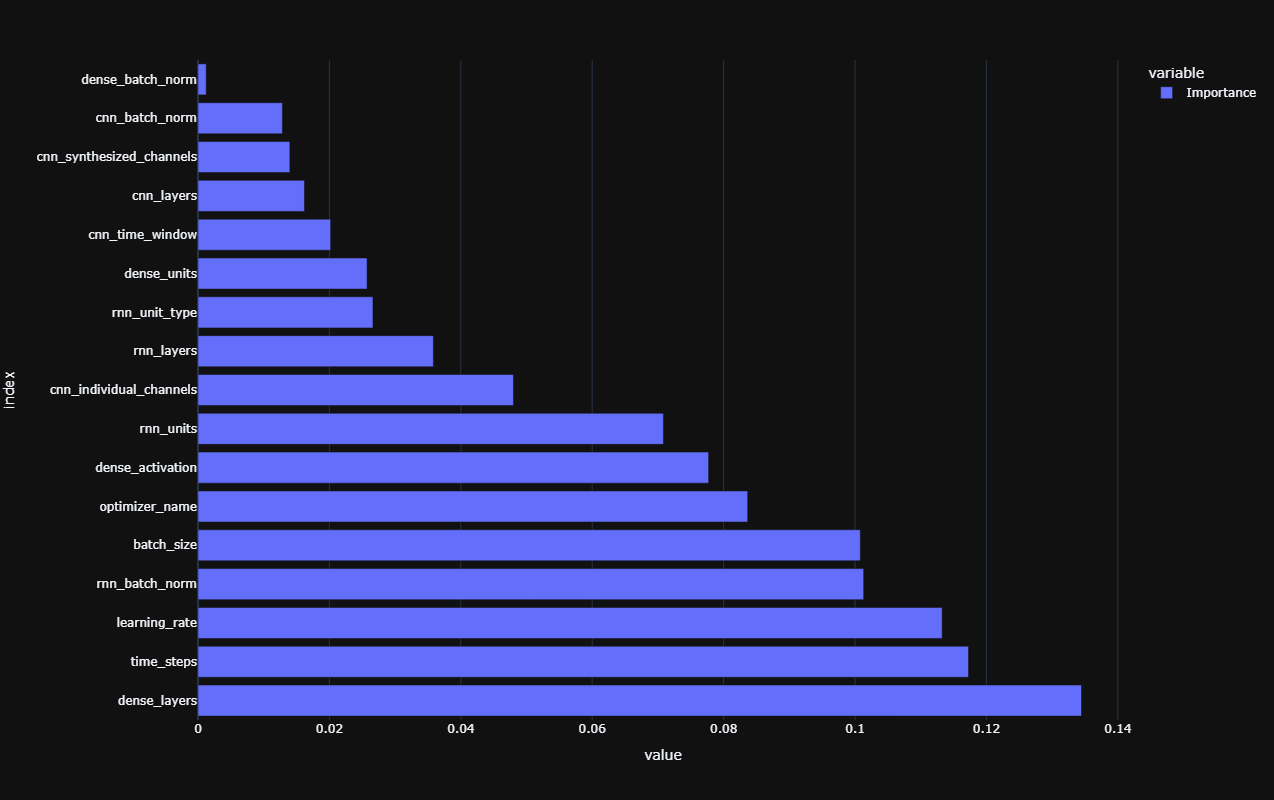

In [9]:
param_import_dic = optuna.importance.get_param_importances(study)
param_import_df = pd.DataFrame(data = param_import_dic.values(),
                               index = param_import_dic.keys(),
                               columns = ['Importance'])
px.bar(
    data_frame = param_import_df,
    template ='plotly_dark',
    orientation = 'h',
    height=800
)

In [10]:
study.best_params

{'cnn_time_window': 17,
 'cnn_individual_channels': 8,
 'cnn_synthesized_channels': 34,
 'cnn_layers': 3,
 'cnn_batch_norm': False,
 'rnn_units': 256,
 'rnn_layers': 1,
 'rnn_batch_norm': True,
 'rnn_unit_type': 'LSTM',
 'dense_layers': 2,
 'dense_units': 64,
 'dense_batch_norm': True,
 'dense_activation': 'Softplus',
 'time_steps': 120,
 'batch_size': 32,
 'learning_rate': 0.009950137960620513,
 'optimizer_name': 'NAdam'}

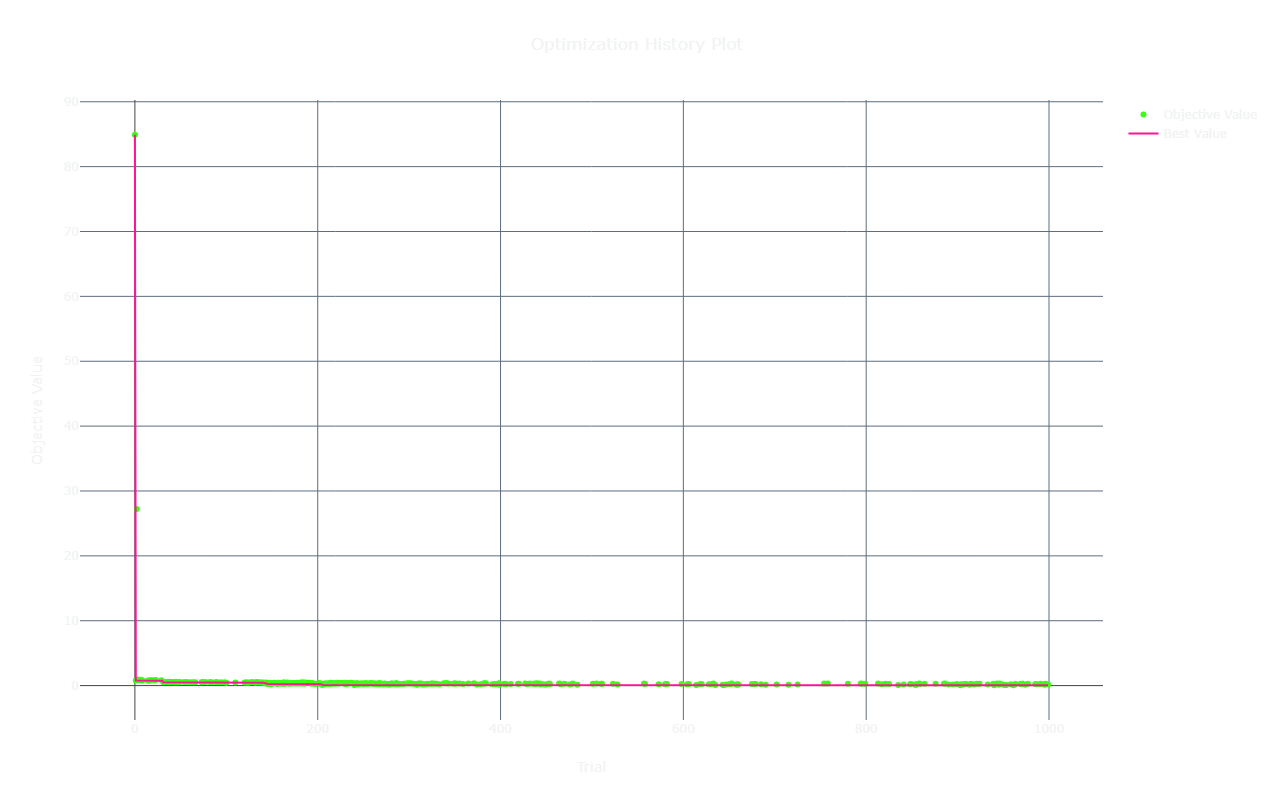

In [11]:
fig = optuna.visualization.plot_optimization_history(study)
fig.update_layout(height=800)

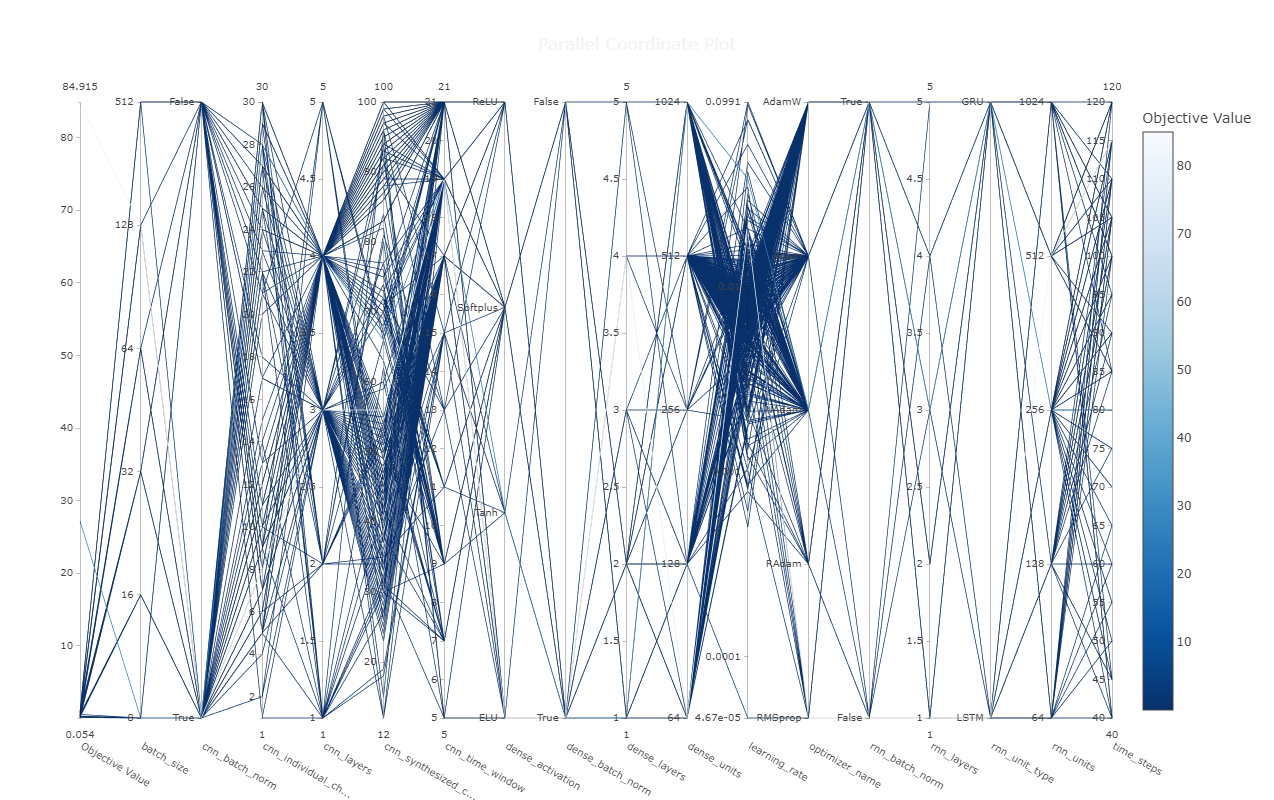

In [12]:
fig = optuna.visualization.plot_parallel_coordinate(study)
fig.update_layout(height=800)

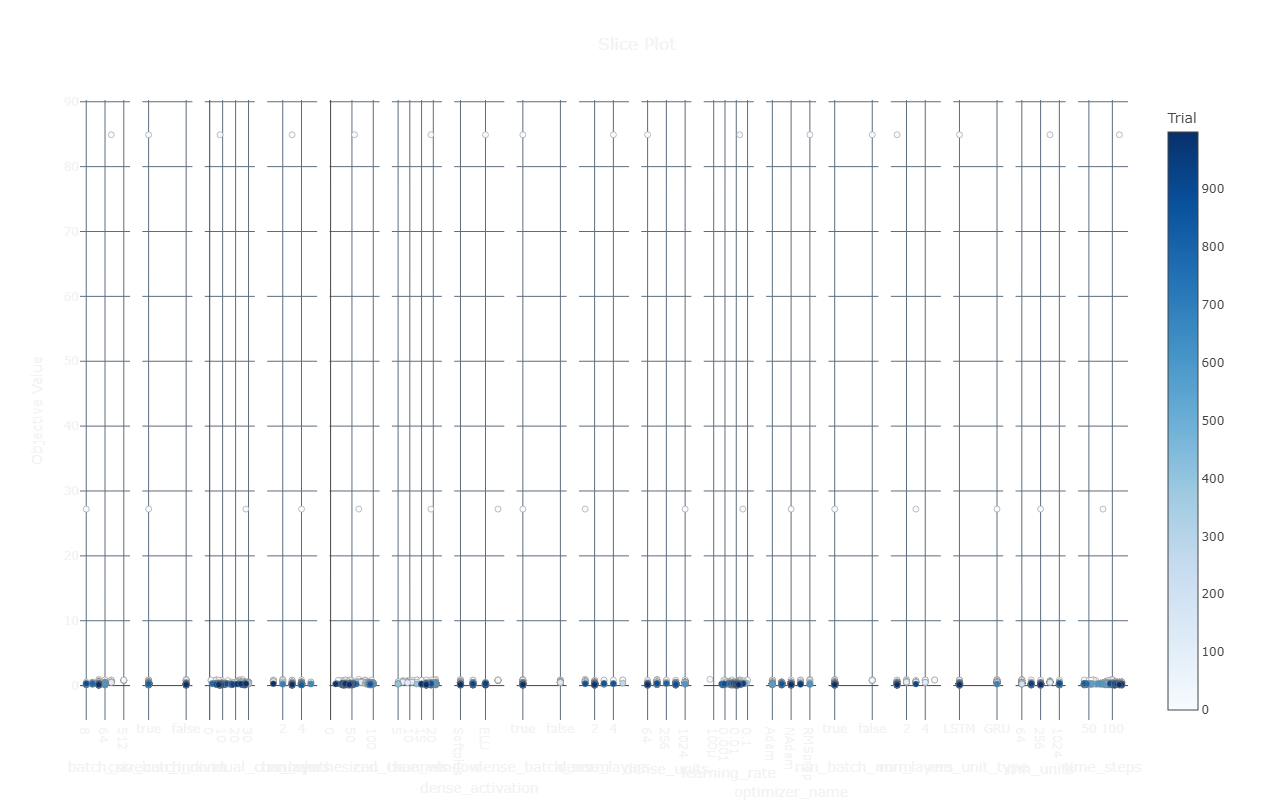

In [13]:
fig = optuna.visualization.plot_slice(study, params=list(study.best_params.keys()))
fig.update_layout(height=800)

In [23]:
# Save study
joblib.dump(study, 'studies/RNNCNN_close_price_t1.pkl')

['studies/RNNCNN_close_price_t1.pkl']

## Create Model 

In [7]:
# Load study
study = joblib.load('studies/RNNCNN_close_price_t1.pkl')

In [8]:
study.best_params

{'cnn_time_window': 17,
 'cnn_individual_channels': 8,
 'cnn_synthesized_channels': 34,
 'cnn_layers': 3,
 'cnn_batch_norm': False,
 'rnn_units': 256,
 'rnn_layers': 1,
 'rnn_batch_norm': True,
 'rnn_unit_type': 'LSTM',
 'dense_layers': 2,
 'dense_units': 64,
 'dense_batch_norm': True,
 'dense_activation': 'Softplus',
 'time_steps': 120,
 'batch_size': 32,
 'learning_rate': 0.009950137960620513,
 'optimizer_name': 'NAdam'}

### Train Model Using Best Hyperparameters

In [16]:
model, results_df = mu.train_RNNCNN_model(
    data=daily_df,
    train_test_split=0.25,
    device=device,
    epochs=100,
    patience=20,
    num_target_vars=1,
    model_training_tries=20,
    save_best_model_path='t1_close_price_best_model/t1_close_price.pt',
    **study.best_params
)

Epoch 00008: reducing learning rate of group 0 to 9.9501e-04.
Epoch 00014: reducing learning rate of group 0 to 9.9501e-05.
Epoch 00018: reducing learning rate of group 0 to 9.9501e-06.
Early stopping: Epoch 21
Best model found at try 0 with MAPE 0.13268977382353375

Early stopping: Epoch 20
Best model found at try 1 with MAPE 0.13014949368579046

Epoch 00007: reducing learning rate of group 0 to 9.9501e-04.
Epoch 00016: reducing learning rate of group 0 to 9.9501e-05.
Epoch 00024: reducing learning rate of group 0 to 9.9501e-06.
Early stopping: Epoch 23
Best model found at try 2 with MAPE 0.07801926221166339

Epoch 00009: reducing learning rate of group 0 to 9.9501e-04.
Epoch 00017: reducing learning rate of group 0 to 9.9501e-05.
Early stopping: Epoch 20
Epoch 00008: reducing learning rate of group 0 to 9.9501e-04.
Epoch 00020: reducing learning rate of group 0 to 9.9501e-05.
Early stopping: Epoch 20
Epoch 00007: reducing learning rate of group 0 to 9.9501e-04.
Epoch 00011: reducing 

In [17]:
results_df

epoch  train_loss       val_loss  val_mape
0     0.0  771.580852    4894.300432  0.203469
1     1.0   45.254623     311.275775  0.059195
2     2.0   54.178080     704.689559  0.087410
3     3.0   39.238380    1654.755608  0.104677
4     4.0   50.633851    2327.318792  0.162481
5     5.0   31.335326    5292.875802  0.259630
6     6.0   36.113850    2170.417128  0.162031
7     7.0   29.629433     717.508537  0.099561
8     8.0   35.595062    5553.053990  0.213732
9     9.0   33.200862    2873.450056  0.152663
10   10.0   30.845942   63336.282589  0.717662
11   11.0   28.139308   26109.590290  0.496829
12   12.0   36.069539    7893.713707  0.272522
13   13.0   29.269695   52512.979353  0.586756
14   14.0   53.761415    5795.625216  0.234261
15   15.0   42.610534  850267.253571  2.265664
16   16.0   38.113783  695291.594643  2.122097
17   17.0   32.299383  825877.925000  2.272918
18   18.0   29.952669  583897.888393  1.967854
19   19.0   38.193627  540504.327679  1.879755
20   20.0   37.887128  719323.973214  2.157346
21   21.0   33.867976  682462.026786  2.107901

### Load Best Model


In [14]:
# Load Study: obtain best hyper-parameters
study = joblib.load('studies/RNNCNN_close_price_t1.pkl')
best_hyper_parameters = study.best_params

# Find model class init parameters
init_parameters = set(inspect.signature(mu.TimeCNNRNN.__init__).parameters.keys())

# Intersection between best hyper-parameters and `init` method of the class
hps = {
    key: value for key, value in best_hyper_parameters.items() 
    if key in init_parameters
}

# Build the model
model = mu.TimeCNNRNN(
    num_vars=daily_df.shape[1] - 1, 
    time_window=best_hyper_parameters['cnn_time_window'], 
    **hps
).to(device)

# Load `state_dict` to the model
model.load_state_dict(torch.load('t1_close_price_best_model/t1_close_price.pt'))
model.eval()

# -------------------------------- Model Results ---------------------------------------
# Build batch x time_steps x variables arrays
x_train, y_train, x_test, y_test = mu.series_to_sequence(
    data=daily_df,
    window_size=best_hyper_parameters['time_steps'],
    num_target_vars=1,
    test_split=0.25
)

# Send tensors to device
x_train = torch.tensor(x_train, dtype=torch.float).to(device)
x_test = torch.tensor(x_test, dtype=torch.float).to(device)
y_hat_train = model(x_train).to('cpu').detach().numpy()
y_hat_test = model(x_test).to('cpu').detach().numpy()

# Create data frames
train_df = pd.DataFrame(columns=['price', 'price_hat'])
train_df['price'] = y_train.reshape((-1,))
train_df['price_hat'] = y_hat_train

test_df = pd.DataFrame(columns=['price', 'price_hat'])
test_df['price'] = y_test.reshape((-1,))
test_df['price_hat'] = y_hat_test

### Model Diagram

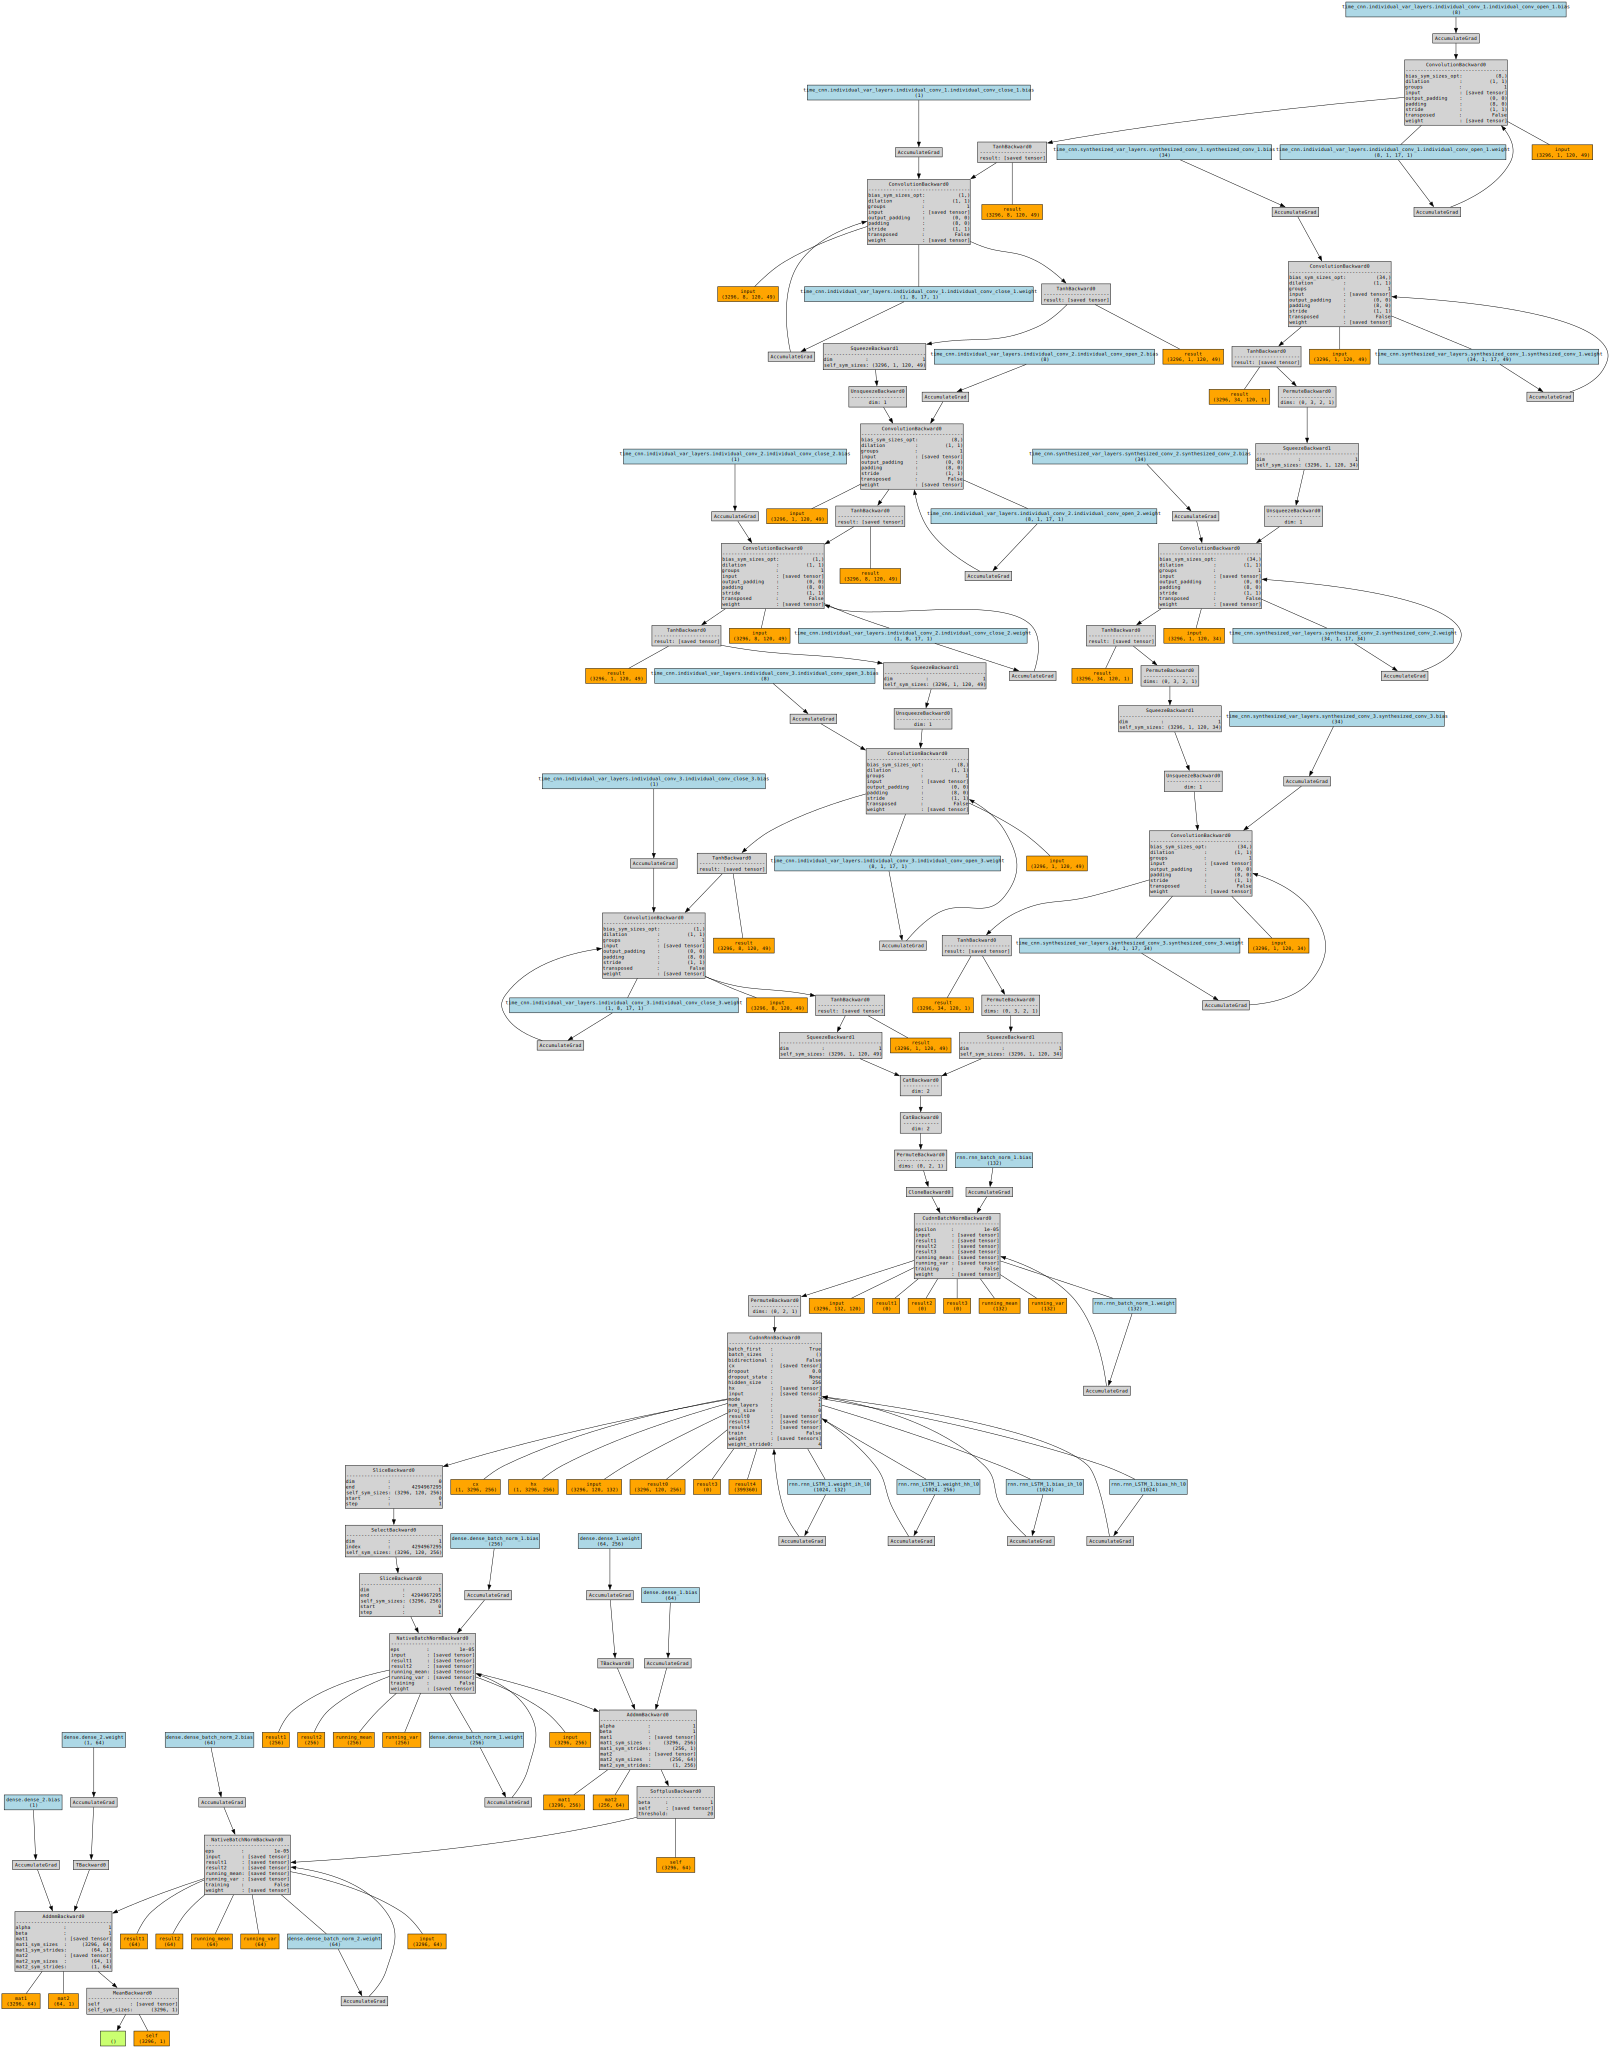

In [16]:
make_dot(
    model(x_train).mean(), 
    params=dict(model.named_parameters()),
    show_attrs=True,
    show_saved=True
)

In [18]:
train_df.head()

price  price_hat
0  16.267141  15.710071
1  16.295647  15.697034
2  16.509504  16.301140
3  16.730488  16.084471
4  16.609304  16.319342

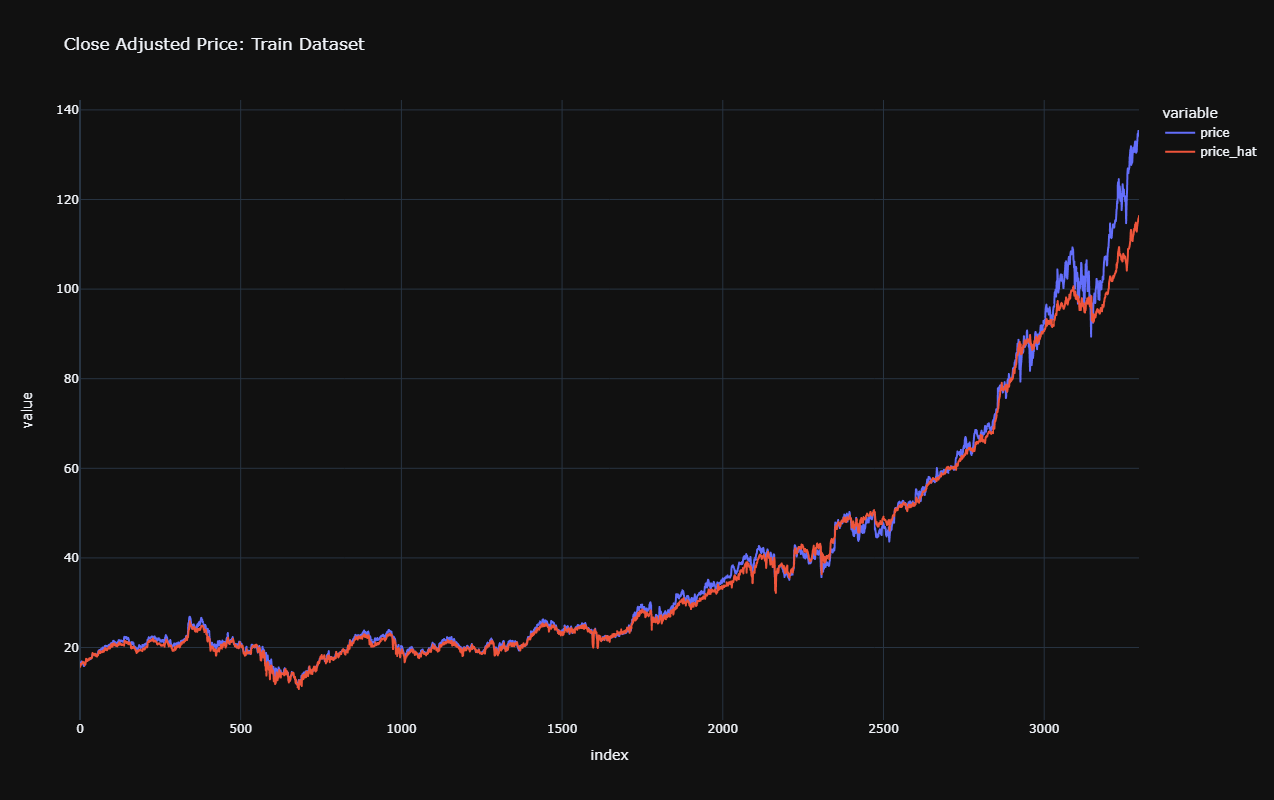

Value
R2    0.987139
RMSE  3.143927
MAE   1.537976
MAPE  0.032566

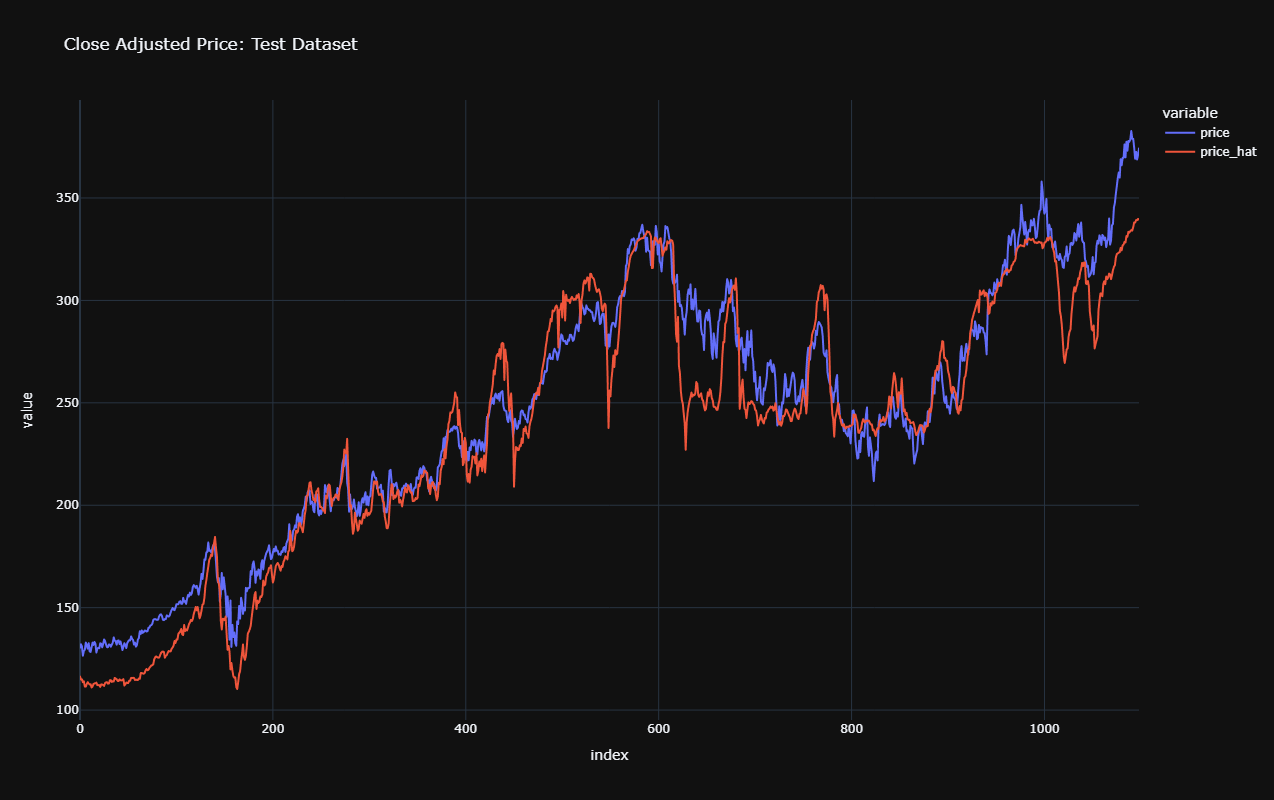

Value
R2     0.920726
RMSE  17.659889
MAE   13.712331
MAPE   0.059308

In [19]:
train_fig = px.line(
    data_frame=train_df,
    template='plotly_dark',
    title='Close Adjusted Price: Train Dataset',
    height=800,
)
test_fig = px.line(
    data_frame=test_df,
    template='plotly_dark',
    title='Close Adjusted Price: Test Dataset',
    height=800
)

display(train_fig)
display(
    mu.regression_report(
        y_observed=train_df['price'].values, 
        y_predicted=train_df['price_hat'].values
    )
)
display(test_fig)
display(
    mu.regression_report(
        y_observed=test_df['price'].values, 
        y_predicted=test_df['price_hat'].values
    )
)

In [23]:
# Test naive shift strategy values
mu.regression_report(
    y_observed=train_df['price'].values[1:],
    y_predicted=train_df['price'].shift(1).values[1:]
)

Value
R2     0.99934
RMSE  0.712211
MAE   0.416937
MAPE  0.011337

In [24]:
mu.regression_report(
    y_observed=test_df['price'].values[1:],
    y_predicted=test_df['price'].shift(1).values[1:]
)

Value
R2    0.994682
RMSE  4.568972
MAE   3.345068
MAPE  0.014081